[Exam pictures](https://photos.app.goo.gl/vENTn2Vp2vrsCW8r5)

**Student Name**: Marco Sabbadin  
**Matricola**: 536040  
**Exam**: Machine Learning, Artificial Neural Networks and Deep Learning  
**Goal**: Predict the `Review Score` using BiLSTM neural network

In [ ]:
import pandas as pd
import numpy as np
import re
import string
import random
import matplotlib.pyplot as plt
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_absolute_error
from tensorflow.keras.initializers import RandomNormal, HeNormal ,GlorotUniform

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error


##  Load the Dataset

We load the `input_data.csv` file containing hotel reviews and scores from GitHub repository.

Keeping only the Review and Review_Score columns, and drop rows with missing values.


In [ ]:
url = 'https://github.com/sabbbaa/DL_project/raw/refs/heads/main/input_data.csv'

df = pd.read_csv(url)
df = df[['Review', 'Review_Score']].dropna()
df.head()

,Review,Review_Score
0,Expensive room rate that didn t include parki...,6.7
1,Bedroom in the basement No windows Very small...,5.8
2,Room ready for a makeover Location,6.3
3,Firstly the lady at the check in desk was qui...,5.8
4,Not being able to park my vehicle due to the ...,3.3


## 2. **INPUT**
 How to (if) preprocess input data;

 Which is, after the preprocessing step, the input of the model:
type, shape, value domain;


We apply the following steps, as described in the written exam:
- Remove `-` and replace it with a space
- Remove any non-alphabetical characters
- Remove punctuation
- Convert to lowercase and tokenize


In [ ]:
def get_words(text):
    text = text.replace('--', ' ')
    words = text.split()
    table = str.maketrans('', '', string.punctuation)
    words = [w.translate(table) for w in words]
    words = [word for word in words if word.isalpha()]
    words = [word.lower() for word in words]
    return words

# Step 2: Apply to all reviews
df['tokens'] = df['Review'].astype(str).apply(get_words)

# Step 3: Flatten all tokens into a single list
all_words = [word for tokens in df['tokens'] for word in tokens]

# Step 4: Extract unique words and assign index manually
unique_words = np.unique(all_words)
unique_word_index = dict((word, idx + 1) for idx, word in enumerate(unique_words))  # start from 1
# Note: index 0 will be reserved for padding

print(f"Total unique words: {len(unique_words)}")
print(f"Unique words:{unique_words[:20]}")
print(list(unique_word_index.items())[:10])


Total unique words: 11458
Unique words:['a' 'aal' 'ab' 'aback' 'abadoneded' 'abandoned' 'abatement' 'abbey' 'abd'
 'abdulrahim' 'abfluss' 'abig' 'ability' 'abit' 'able' 'abled' 'about'
 'above' 'abroad' 'abrubt']
[(np.str_('a'), 1), (np.str_('aal'), 2), (np.str_('ab'), 3), (np.str_('aback'), 4), (np.str_('abadoneded'), 5), (np.str_('abandoned'), 6), (np.str_('abatement'), 7), (np.str_('abbey'), 8), (np.str_('abd'), 9), (np.str_('abdulrahim'), 10)]


## Tokenization and Sequences

We convert the cleaned text into integer sequences and pad them to a fixed length.


In [ ]:
# Convert each review to its integer sequence
df['int_seq'] = df['tokens'].apply(lambda tokens: [unique_word_index.get(word, 0) for word in tokens])

MAX_WORDS = len(unique_word_index) + 1  # +1 for padding index 0
MAX_LEN = 150  # Chosen value
padded_sequences = pad_sequences(df['int_seq'], maxlen=MAX_LEN, padding='post', truncating='post')


## 6.  **Train, Validation and Test Split**
The dataset is split into:

Training Set (64%)

Validation Set (16%)

Test Set (20%)

This allows for unbiased evaluation of generalization and model tuning.




In [ ]:
X = padded_sequences
y = df['Review_Score'].values

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)



## 3-4-5. **Model Architecture: Embedding → BiLSTM → Dropout → Dense**

- **Output**: 1 neuron with activation to be determined with GridSearch.
- **Loss**: Mean Squared Error
- **Optimizer**: Adam
- **Weight Initialization**: He Normal or Glorot (dense), RandomUniform(Embedding)
- **Early stopping** and **L2_regularization**: (**CHANGE**) added for preventing overfitting

(**CHANGE**) : I have implemented a semplified grid search (5 epochs) between activations (`relu`, `linear`) with the respective most optimal initializers.

To fit within the maximum execution time imposed (few mins) I have directly chosen to avoid `leaky-relu`. The search grid has been discussed in the theoretical part.


In [ ]:
EMBEDDING_DIM = 64
LSTM_UNITS = 64
DROPOUT_RATE = 0.4
L2_REG = 1e-4
results = []
activations = ['linear', 'relu']

for act in activations:
    print(f"\n Training model with activation: {act}")

    # Select initializer based on activation
    if act == 'relu':
        dense_initializer = HeNormal()
    else:
        dense_initializer = GlorotUniform()

    model = Sequential([
        Embedding(input_dim=MAX_WORDS, output_dim=EMBEDDING_DIM,
              embeddings_initializer=RandomNormal(mean=0.0, stddev=1.0)),
        Bidirectional(LSTM(LSTM_UNITS)),
        Dropout(DROPOUT_RATE),
        Dense(1, activation= act,
          kernel_regularizer=l2(L2_REG),
          kernel_initializer=dense_initializer)
    ])

    model.compile(optimizer='adam', loss='mse', metrics=['mse'])

    model.fit(X_train, y_train, epochs=5, batch_size=64, validation_split=0.2, verbose=0)

    val_loss, val_mse = model.evaluate(X_val, y_val, verbose=0)
    test_loss, test_mse = model.evaluate(X_test, y_test, verbose=0)
    y_pred = model.predict(X_test).flatten()
    test_mae = mean_absolute_error(y_test, y_pred)

    results.append({
        'activation': act,
        'val_mse': val_mse,
    })
model.summary()


 Training model with activation: linear
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step

 Training model with activation: relu
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ (None, 150, 64)        │       733,376 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 128)            │        66,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,398,661 (9.15 MB)

 Trainable params: 799,553 (3.05 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,599,108 (6.10 MB)

**Select the best activation and use it:**

In [ ]:
print("\n Activation Function Comparison (5 epochs each):")
for res in results:
    print(f"  Activation: {res['activation']}")
    print(f"   Val MSE:   {res['val_mse']:.4f}")

best_model = min(results, key=lambda x: x['val_mse'])
best_activation = best_model['activation']

print("\n Best Activation Function Based on Validation MSE: ")
print(f"{best_model['activation']}\n")

# Select initializer based on activation
if best_activation == 'relu':
    dense_initializer = HeNormal()
else:
    dense_initializer = GlorotUniform()

model = Sequential([
        Embedding(input_dim=MAX_WORDS, output_dim=EMBEDDING_DIM,
              embeddings_initializer=RandomNormal(mean=0.0, stddev=1.0)),
        Bidirectional(LSTM(LSTM_UNITS)),
        Dropout(DROPOUT_RATE),
        Dense(1, activation= best_activation,
          kernel_regularizer=l2(L2_REG),
          kernel_initializer=dense_initializer)
    ])

model.compile(optimizer='adam', loss='mse', metrics=['mse'])

# Early stopping to prevent overfitting
early_stop = EarlyStopping(monitor='val_mse', patience=4, restore_best_weights=True)


 Activation Function Comparison (5 epochs each):
  Activation: linear
   Val MSE:   1.7476
  Activation: relu
   Val MSE:   1.7661

 Best Activation Function Based on Validation MSE: 
linear



## Training the Model


The selected model is trained for up to 20 epochs(run with GPU), with Early Stopping enabled (patience = 2) to prevent overfitting.

A validation split of 20% of the training data is used during training.

  



In [ ]:
history = model.fit(X_train, y_train,
                        validation_split=0.2,
                        epochs=20,
                        batch_size=64,
                        callbacks=[early_stop],
                        )


Epoch 1/20
138/138 ━━━━━━━━━━━━━━━━━━━━ 8s 24ms/step - loss: 11.5502 - mse: 11.5499 - val_loss: 2.1084 - val_mse: 2.1081
Epoch 2/20
138/138 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 2.4848 - mse: 2.4846 - val_loss: 1.9843 - val_mse: 1.9841
Epoch 3/20
138/138 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 2.2550 - mse: 2.2547 - val_loss: 1.9378 - val_mse: 1.9376
Epoch 4/20
138/138 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 2.0603 - mse: 2.0601 - val_loss: 1.8378 - val_mse: 1.8375
Epoch 5/20
138/138 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - loss: 1.9336 - mse: 1.9333 - val_loss: 1.7207 - val_mse: 1.7204
Epoch 6/20
138/138 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 1.8521 - mse: 1.8518 - val_loss: 1.7161 - val_mse: 1.7158
Epoch 7/20
138/138 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 1.7416 - mse: 1.7414 - val_loss: 1.6374 - val_mse: 1.6372
Epoch 8/20
138/138 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 1.6413 - mse: 1.6410 - val_loss: 1.6781 - val_mse: 1.6778
Epoch 9/20
138/138 ━━━━━━━━━━━━━━━━━━━━ 2s 15m

## 6. **MODEL EVALUATION**.
*How would you assess (in which setting) the
generalization capabilities of the model on unseen data?*


  **Plot Training Curves**:

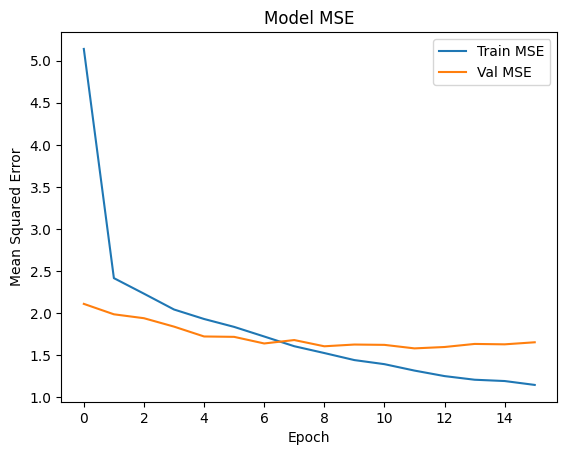

In [ ]:
plt.plot(history.history['mse'], label='Train MSE')
plt.plot(history.history['val_mse'], label='Val MSE')
plt.title('Model MSE')
plt.xlabel('Epoch')
plt.ylabel('Mean Squared Error')
plt.legend()
plt.show()

## Evaluate Model on Test Set

  -MSE (Mean Squared Error): Measures average squared difference between actual
    and predicted scores.

  -MAE (Mean Absolute Error)(***CHANGE***): Complements MSE by measuring average absolute error.

  -Error Histogram: A plot of (true - predicted)(***CHANGE***) scores helps visualize prediction consistency.




44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.5885 - mse: 1.5883
Test MSE: 1.6381
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
Test MAE: 0.9993


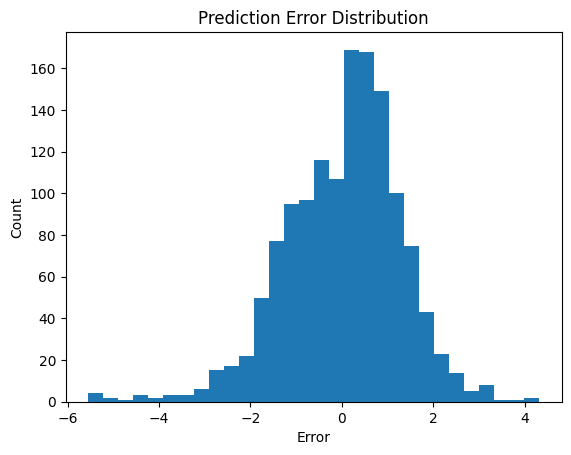

In [ ]:
loss, mse = model.evaluate(X_test, y_test)
print(f"Test MSE: {mse:.4f}")

y_pred = model.predict(X_test).flatten()
mae = mean_absolute_error(y_test, y_pred)
print(f"Test MAE: {mae:.4f}")

# Plot prediction error distribution
errors = y_test - y_pred
plt.hist(errors, bins=30)
plt.title('Prediction Error Distribution')
plt.xlabel('Error')
plt.ylabel('Count')
plt.show()

**Error Analysis**

To evaluate the model’s prediction behavior on unseen data, we plotted the distribution of prediction errors (i.e., true score − predicted score).

The histogram shows an approximately Gaussian distribution, centered around 0. This indicates that the model has no strong bias in over- or under-prediction.

Most prediction errors lie within the range [-2, +2], which suggests the model performs reasonably well given the nature of the regression task and the input variability.

A few outliers are visible (errors below -4), but these represent a small minority and are likely due to noisy or ambiguous reviews.

Conclusion: The error distribution confirms that the model generalizes well and is suitable for predicting the Review Score with acceptable accuracy.

## Using the model


We sample 5 random test reviews to:

-Convert their padded integer sequences back into readable word snippets.

-Compare actual vs. predicted scores.

-Provide insight into how the model interprets and scores the reviews.



In [ ]:
# Predict scores on the test set
predicted_scores = model.predict(X_test)

# Choose 5 random indices
sample_indices = random.sample(range(len(X_test)), 5)

for idx in sample_indices:
    # Get original padded sequence
    padded_review = X_test[idx]
    # Convert back from integers to words for readability
    original_tokens = [word for word, i in unique_word_index.items() if i in padded_review]
    original_text = " ".join(original_tokens[:50]) + "..."

    actual_score = y_test[idx]
    predicted_score = predicted_scores[idx][0]

    print(f"\n Review snippet: {original_text}")
    print(f" Actual Score: {actual_score}")
    print(f" Predicted Score: {predicted_score:.2f}")


44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step

 Review snippet: albert hall neat...
 Actual Score: 8.8
 Predicted Score: 9.56

 Review snippet: a absolutely after always and are big breakfast but can clean close dirty disorganized don drinks everything evething excess executive for from general good guests have hotel i in is it itself lack location longe looking lot lounge manager mark my need new nice not of ok one overpay perfect...
 Actual Score: 6.5
 Predicted Score: 5.26

 Review snippet: and comfort decor fantastic just ok room staff was...
 Actual Score: 9.6
 Predicted Score: 8.30

 Review snippet: everything nothing...
 Actual Score: 2.5
 Predicted Score: 5.59

 Review snippet: rest room...
 Actual Score: 7.9
 Predicted Score: 8.29
